### Imports

In [33]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from scipy.stats import norm

### Get NVDA Data - stock and options

expiration date = 2025-08-01

In [34]:
ticker = yf.Ticker('NVDA')

expiration_date = '2025-08-01'

options = ticker.option_chain(expiration_date)

calls = options.calls

puts = options.puts

calls['Option'] = 'C'

puts['Option'] = 'P'

options = pd.concat(objs=[calls, puts], ignore_index=True)

### Black-Scholes Model

- We use BSM to understand, compare and make decisions based on the prices calculated.

- The market can be distorted due to various reasons which is why we calculate the fair theoretical fair price for the options and make our comparisons.

- We can calculate the implied volatility using the market price of the option with the help of BSM.

In [35]:
class BlackScholesModel:

    def __init__(self):
        pass

    def d1(self, S0, K, T, r, sigma):
        return (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    
    def d2(self, S0, K, T, r, sigma):
        return self.d1(S0, K, T, r, sigma) - (sigma * np.sqrt(T))
    
    def call_price(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        d2 = self.d2(S0, K, T, r, sigma)
        return (S0 * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))
    
    def put_price(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        d2 = self.d2(S0, K, T, r, sigma)
        return (-S0 * norm.cdf(-d1)) + (K * np.exp(-r * T) * norm.cdf(-d2))

bsm = BlackScholesModel()

In [36]:
options.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option
0,NVDA250801C00020000,2025-07-10 19:54:31+00:00,20.0,144.15,144.85,145.35,0.0,0.0,3.0,22,3.742188,True,REGULAR,USD,C
1,NVDA250801C00055000,2025-07-02 19:50:00+00:00,55.0,102.55,110.05,110.55,0.0,0.0,1.0,6,2.193364,True,REGULAR,USD,C
2,NVDA250801C00065000,2025-06-25 18:01:46+00:00,65.0,88.15,100.10,100.55,0.0,0.0,NaN,1,1.899415,True,REGULAR,USD,C
3,NVDA250801C00075000,2025-07-01 19:40:06+00:00,75.0,78.93,90.00,90.50,0.0,0.0,7.0,11,1.578127,True,REGULAR,USD,C
4,NVDA250801C00080000,2025-07-07 13:51:52+00:00,80.0,79.21,85.15,85.60,0.0,0.0,4.0,70,1.539065,True,REGULAR,USD,C


In [37]:
today_date = datetime.strptime(date.today().strftime("%Y-%m-%d"), "%Y-%m-%d") 
expiration_date = datetime.strptime(expiration_date, "%Y-%m-%d")
days_to_expiry = (expiration_date - today_date).days
days_to_expiry

21

In [38]:
r = 0.05
T = days_to_expiry/365
S0 = ticker.history(period='1d')['Close'].iloc[-1]

def theoretical_option_price(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    if row['Option'] == 'C':
        return bsm.call_price(S0, K, T, r, sigma)
    return bsm.put_price(S0, K, T, r, sigma)

options['theoreticalPriceBSM'] = options.apply(theoretical_option_price, axis=1)

### Greeks

- Delta: Change in option price relative to a $1 move in the underlying [-1,1]

- Gamma: Change in delta as the underlying price changes

- Theta: The amount of value the option will lose each day as it closes to expiry. The rate of change increases as it approaches expiry.

- Vega: Sensitivity of the option's price to the chnages in the expected market volatility.

In [39]:
class OptionGreeks:
    
    def __init__(self):
        pass

    def d1(self, S0, K, T, r, sigma):
        return (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    
    def d2(self, S0, K, T, r, sigma):
        return self.d1(S0, K, T, r, sigma) - (sigma * np.sqrt(T))
    
    def delta(self, S0, K, T, r, sigma, option_type):
        d1 = self.d1(S0, K, T, r, sigma)
        if option_type == 'C':
            return norm.cdf(d1)
        return norm.cdf(d1) - 1
    
    def gamma(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        return norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
    
    def theta(self, S0, K, T, r, sigma, option_type):
        d1 = self.d1(S0, K, T, r, sigma)
        d2 = self.d2(S0, K, T, r, sigma)
        first_term = - (S0 * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
        if option_type == 'C':
            second_term = - r * K * np.exp(-r * T) * norm.cdf(d2)
        else:
            second_term = r * K * np.exp(-r * T) * norm.cdf(-d2)
        return first_term + second_term  

    def vega(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        return S0 * norm.pdf(d1) * np.sqrt(T)

og = OptionGreeks()

def option_delta(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    option_type = row['Option']
    return og.delta(S0, K, T, r, sigma, option_type)

def option_gamma(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    return og.gamma(S0, K, T, r, sigma)

def option_theta(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    option_type = row['Option']
    return og.theta(S0, K, T, r, sigma, option_type)

def option_vega(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    return og.vega(S0, K, T, r, sigma)

options['delta'] = options.apply(option_delta, axis=1) 

options['gamma'] = options.apply(option_gamma, axis=1) 

options['theta'] = options.apply(option_theta, axis=1)

options['vega'] = options.apply(option_vega, axis=1)
    

### Analyzing Greeks

1. Greeks vs Strike Price (Call Options)

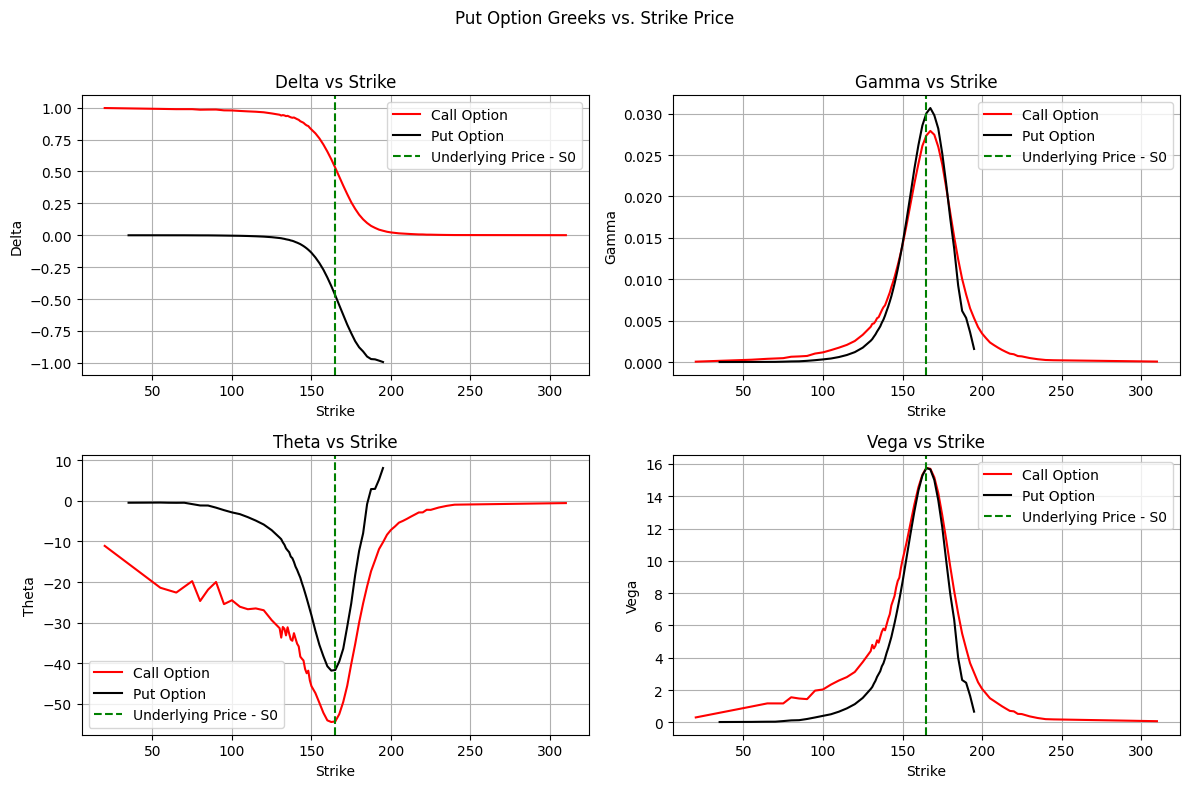

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Put Option Greeks vs. Strike Price')

calls = options[options['Option'] == 'C']
puts = options[options['Option'] == 'P']

# Delta
axs[0, 0].plot(calls['strike'], calls['delta'], label='Call Option', color='red')
axs[0, 0].plot(puts['strike'], puts['delta'], label='Put Option', color='black')
axs[0, 0].axvline(S0, label='Underlying Price - S0', color='green', linestyle='--')
axs[0, 0].set_title('Delta vs Strike')
axs[0, 0].set_xlabel('Strike')
axs[0, 0].set_ylabel('Delta')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Gamma
axs[0, 1].plot(calls['strike'], calls['gamma'], label='Call Option', color='red')
axs[0, 1].plot(puts['strike'], puts['gamma'], label='Put Option', color='black')
axs[0, 1].axvline(S0, label='Underlying Price - S0', color='green', linestyle='--')
axs[0, 1].set_title('Gamma vs Strike')
axs[0, 1].set_xlabel('Strike')
axs[0, 1].set_ylabel('Gamma')
axs[0, 1].legend()
axs[0, 1].grid(True)


# Theta
axs[1, 0].plot(calls['strike'], calls['theta'], label='Call Option', color='red')
axs[1, 0].plot(puts['strike'], puts['theta'], label='Put Option', color='black')
axs[1, 0].axvline(S0, label='Underlying Price - S0', color='green', linestyle='--')
axs[1, 0].set_title('Theta vs Strike')
axs[1, 0].set_xlabel('Strike')
axs[1, 0].set_ylabel('Theta')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Vega
axs[1, 1].plot(calls['strike'], calls['vega'], label='Call Option', color='red')
axs[1, 1].plot(puts['strike'], puts['vega'], label='Put Option', color='black')
axs[1, 1].axvline(S0, label='Underlying Price - S0', color='green', linestyle='--')
axs[1, 1].set_title('Vega vs Strike')
axs[1, 1].set_xlabel('Strike')
axs[1, 1].set_ylabel('Vega')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In the above plots, we compare the changes in the greeks wrt to the strike price for call and put options of NVDA.

##### Delta

Delta ranges between [0, 1] for call options and [-1, 0] for put options. 

It is approximately 0.5 for ATM call option and -0.5 for ATM put option.

#### Gamma

Gamma is the change in delta as the underlying price changes and it has the highest value (here) close to S0.

Gamma follows a bell curve for both the options.

##### Theta

Theta is mostly negative as seen in the plot meaning that both the options are losing value over time (theta definition). 

For call option, we have a greater negative value of Theta which means that the call option is decaying in value faster than the put option.

##### Vega 

Vega is highest ATM for both Call and Put Options

### Delta Hedging